In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Scale to [0, 1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


In [ ]:
def load_data():
  transform = transforms.Compose([
      transforms.ToTensor()
  ])

  train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  test_data  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)
  return train_loader, test_loader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_ae(train_loader):
  model = ConvAutoencoder().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.MSELoss()

  train_losses = []

  for epoch in range(20):
      model.train()
      epoch_loss = 0
      for imgs, _ in tqdm(train_loader):
          imgs = imgs.to(device)
          output = model(imgs)
          loss = criterion(output, imgs)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      avg_loss = epoch_loss / len(train_loader)
      train_losses.append(avg_loss)
      print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
  return train_losses, model

In [ ]:
def show_reconstructions(model, dataloader):
    model.eval()
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)
    with torch.no_grad():
        recons = model(imgs)
    imgs = imgs.cpu()
    recons = recons.cpu()
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0, i].imshow(np.transpose(imgs[i], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[1, i].imshow(np.transpose(recons[i], (1, 2, 0)))
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    plt.tight_layout()
    plt.show()

In [ ]:
def extract_latents(model, dataloader, method='tsne'):
    model.eval()
    latents, labels = [], []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            z = model.encoder(imgs).view(imgs.size(0), -1)
            latents.append(z.cpu().numpy())
            labels.extend(lbls.numpy())
    latents = np.concatenate(latents)

    if method == 'tsne':
        reduced = TSNE(n_components=2).fit_transform(latents)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=10)
    plt.colorbar()
    plt.title(f'Latent Space ({method.upper()})')
    plt.show()

In [ ]:
def plot_MSE(train_losses):
  plt.plot(train_losses)
  plt.xlabel('Epoch')
  plt.ylabel('Average MSE Loss')
  plt.title('Training Loss Over Epochs')
  plt.grid()
  plt.show()

In [ ]:
def add_noise(imgs, noise_level=0.2):
    noise = torch.randn_like(imgs) * noise_level
    return torch.clamp(imgs + noise, 0., 1.)

def compare_latents(model, dataloader):
    model.eval()
    clean_latents, noisy_latents = [], []
    with torch.no_grad():
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            noisy_imgs = add_noise(imgs)
            z_clean = model.encoder(imgs).view(imgs.size(0), -1).cpu().numpy()
            z_noisy = model.encoder(noisy_imgs).view(imgs.size(0), -1).cpu().numpy()
            clean_latents.append(z_clean)
            noisy_latents.append(z_noisy)
    clean_latents = np.concatenate(clean_latents)
    noisy_latents = np.concatenate(noisy_latents)
    reduced_clean = PCA(n_components=2).fit_transform(clean_latents)
    reduced_noisy = PCA(n_components=2).fit_transform(noisy_latents)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(reduced_clean[:, 0], reduced_clean[:, 1], s=5)
    plt.title("Clean Inputs Latent Space")
    plt.subplot(1, 2, 2)
    plt.scatter(reduced_noisy[:, 0], reduced_noisy[:, 1], s=5)
    plt.title("Noisy Inputs Latent Space")
    plt.show()

In [ ]:
def add_gaussian_noise(images, std_dev):
    noise = torch.randn_like(images) * std_dev
    noisy_imgs = torch.clamp(images + noise, 0., 1.)
    return noisy_imgs

In [ ]:
def train_dae(model, train_loader, noise_std, epochs=20):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for imgs, _ in tqdm(train_loader, desc=f"DAE Training σ={noise_std} | Epoch {epoch+1}/{epochs}"):
            imgs = imgs.to(device)
            noisy_imgs = add_gaussian_noise(imgs, noise_std).to(device)
            outputs = model(noisy_imgs)
            loss = criterion(outputs, imgs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"[σ={noise_std}] Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return train_losses

In [ ]:
def visualize_denoising(model, dataloader, noise_std, title="Denoising"):
    model.eval()
    imgs, _ = next(iter(dataloader))
    noisy_imgs = add_gaussian_noise(imgs, noise_std)

    imgs = imgs.to(device)
    noisy_imgs = noisy_imgs.to(device)

    with torch.no_grad():
        outputs = model(noisy_imgs)

    imgs = imgs.cpu()
    noisy_imgs = noisy_imgs.cpu()
    outputs = outputs.cpu()

    fig, axes = plt.subplots(3, 10, figsize=(15, 4))
    for i in range(10):
        axes[0, i].imshow(np.transpose(imgs[i], (1, 2, 0)))
        axes[1, i].imshow(np.transpose(noisy_imgs[i], (1, 2, 0)))
        axes[2, i].imshow(np.transpose(outputs[i], (1, 2, 0)))
        for j in range(3):
            axes[j, i].axis("off")
    axes[0, 0].set_ylabel("Clean", fontsize=12)
    axes[1, 0].set_ylabel("Noisy", fontsize=12)
    axes[2, 0].set_ylabel("Reconstructed", fontsize=12)
    plt.suptitle(f"{title} (σ={noise_std})", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_ae_dae_losses(ae_losses, dae_losses_dict):
    plt.figure(figsize=(10, 6))
    plt.plot(ae_losses, label='AE (No Noise)')
    for name, (_, losses) in dae_losses_dict.items():
        plt.plot(losses, label=name)
    plt.xlabel("Epochs")
    plt.ylabel("Average MSE Loss")
    plt.title("Training Loss: AE vs DAE")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def extract_latent_features(model, dataloader, max_samples=5000):
    model.eval()
    features, labels = [], []
    count = 0
    with torch.no_grad():
        for imgs, lbls in dataloader:
            if count >= max_samples:
                break
            imgs = imgs.to(device)
            z = model.encoder(imgs).view(imgs.size(0), -1).cpu().numpy()
            features.append(z)
            labels.extend(lbls.numpy())
            count += imgs.size(0)
    return np.concatenate(features), np.array(labels)

def evaluate_feature_quality_sklearn(model, train_loader, test_loader, max_samples=1000):
    X_train, y_train = extract_latent_features(model, train_loader, max_samples=max_samples)
    X_test, y_test = extract_latent_features(model, test_loader, max_samples=max_samples)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf = LogisticRegression(max_iter=50, solver='saga', n_jobs=-1, verbose=0)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    return acc

In [ ]:
def main():
  train_loader, test_loader = load_data()
  train_losses, model = train_ae(train_loader)
  plot_MSE(train_losses)
  show_reconstructions(model, test_loader)
  extract_latents(model, test_loader, method='tsne')
  compare_latents(model, test_loader)
  train_dae(model, train_loader, noise_std=0.1)
  noise_levels = [0.1, 0.3, 0.5]
  dae_losses_dict = {}

  for sigma in noise_levels:
      dae_model = ConvAutoencoder()
      losses = train_dae(dae_model, train_loader, sigma)
      dae_losses_dict[f"DAE σ={sigma}"] = (dae_model, losses)
  visualize_denoising(model, test_loader, noise_std=0.1)
  plot_ae_dae_losses(train_losses, dae_losses_dict)
  extract_latent_features(model, test_loader, max_samples=1000)
  acc = evaluate_feature_quality_sklearn(model, train_loader, test_loader, max_samples=1000)
  start = time.time()
  ae_acc = evaluate_feature_quality_sklearn(model, train_loader, test_loader)
  print(f"AE Feature Accuracy: {ae_acc:.4f} | Time: {time.time() - start:.2f}s")

  for noise_level, (dae_model, _) in dae_losses_dict.items():
      start = time.time()
      acc = evaluate_feature_quality_sklearn(dae_model, train_loader, test_loader)
      print(f"{noise_level} DAE Feature Accuracy: {acc:.4f} | Time: {time.time() - start:.2f}s")

100%|██████████| 391/391 [00:08<00:00, 44.53it/s]


Epoch 1, Loss: 0.0167


100%|██████████| 391/391 [00:09<00:00, 41.98it/s]


Epoch 2, Loss: 0.0070


100%|██████████| 391/391 [00:09<00:00, 41.81it/s]


Epoch 3, Loss: 0.0053


100%|██████████| 391/391 [00:09<00:00, 41.47it/s]


Epoch 4, Loss: 0.0044


100%|██████████| 391/391 [00:08<00:00, 43.77it/s]


Epoch 5, Loss: 0.0037


100%|██████████| 391/391 [00:09<00:00, 42.46it/s]


Epoch 6, Loss: 0.0033


100%|██████████| 391/391 [00:09<00:00, 41.83it/s]


Epoch 7, Loss: 0.0029


100%|██████████| 391/391 [00:09<00:00, 39.65it/s]


Epoch 8, Loss: 0.0026


100%|██████████| 391/391 [00:09<00:00, 41.80it/s]


Epoch 9, Loss: 0.0024


100%|██████████| 391/391 [00:08<00:00, 44.44it/s]


Epoch 10, Loss: 0.0022


100%|██████████| 391/391 [00:09<00:00, 41.65it/s]


Epoch 11, Loss: 0.0021


100%|██████████| 391/391 [00:09<00:00, 41.31it/s]


Epoch 12, Loss: 0.0019


100%|██████████| 391/391 [00:09<00:00, 41.73it/s]


Epoch 13, Loss: 0.0018


100%|██████████| 391/391 [00:08<00:00, 44.72it/s]


Epoch 14, Loss: 0.0017


100%|██████████| 391/391 [00:09<00:00, 39.31it/s]


Epoch 15, Loss: 0.0016


100%|██████████| 391/391 [00:09<00:00, 41.90it/s]


Epoch 16, Loss: 0.0016


100%|██████████| 391/391 [00:09<00:00, 41.91it/s]


Epoch 17, Loss: 0.0015


100%|██████████| 391/391 [00:09<00:00, 43.11it/s]


Epoch 18, Loss: 0.0015


100%|██████████| 391/391 [00:09<00:00, 43.32it/s]


Epoch 19, Loss: 0.0014


100%|██████████| 391/391 [00:09<00:00, 42.04it/s]


Epoch 20, Loss: 0.0014


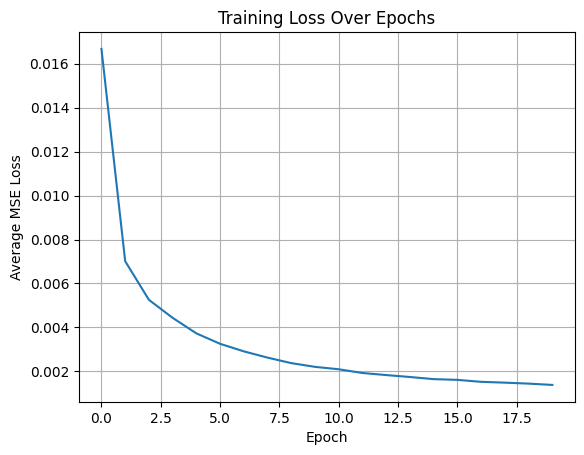

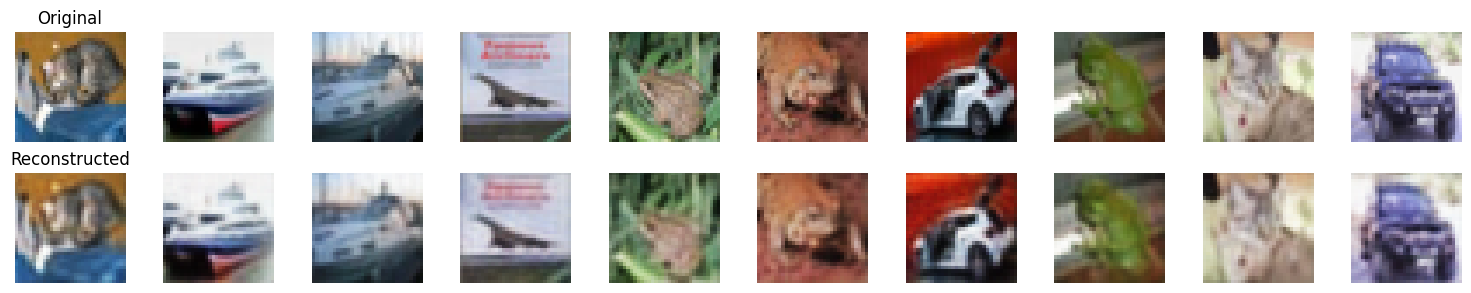

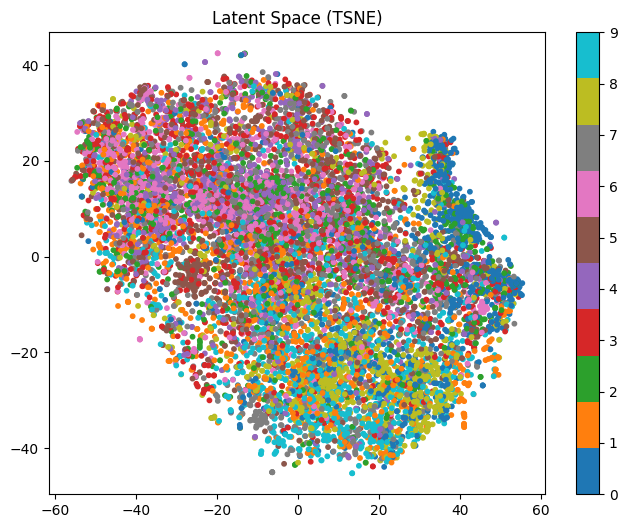

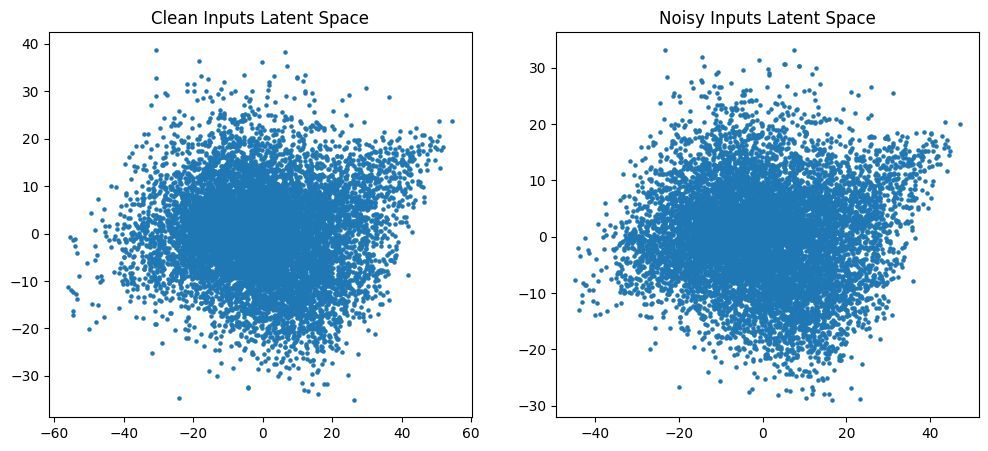

DAE Training σ=0.1 | Epoch 1/20: 100%|██████████| 391/391 [00:09<00:00, 42.87it/s]


[σ=0.1] Epoch 1/20, Loss: 0.0039


DAE Training σ=0.1 | Epoch 2/20: 100%|██████████| 391/391 [00:09<00:00, 40.26it/s]


[σ=0.1] Epoch 2/20, Loss: 0.0026


DAE Training σ=0.1 | Epoch 3/20: 100%|██████████| 391/391 [00:09<00:00, 40.43it/s]


[σ=0.1] Epoch 3/20, Loss: 0.0026


DAE Training σ=0.1 | Epoch 4/20: 100%|██████████| 391/391 [00:09<00:00, 39.98it/s]


[σ=0.1] Epoch 4/20, Loss: 0.0025


DAE Training σ=0.1 | Epoch 5/20: 100%|██████████| 391/391 [00:09<00:00, 41.21it/s]


[σ=0.1] Epoch 5/20, Loss: 0.0025


DAE Training σ=0.1 | Epoch 6/20: 100%|██████████| 391/391 [00:09<00:00, 41.44it/s]


[σ=0.1] Epoch 6/20, Loss: 0.0025


DAE Training σ=0.1 | Epoch 7/20: 100%|██████████| 391/391 [00:09<00:00, 40.22it/s]


[σ=0.1] Epoch 7/20, Loss: 0.0025


DAE Training σ=0.1 | Epoch 8/20: 100%|██████████| 391/391 [00:09<00:00, 40.19it/s]


[σ=0.1] Epoch 8/20, Loss: 0.0024


DAE Training σ=0.1 | Epoch 9/20: 100%|██████████| 391/391 [00:09<00:00, 40.14it/s]


[σ=0.1] Epoch 9/20, Loss: 0.0024


DAE Training σ=0.1 | Epoch 10/20: 100%|██████████| 391/391 [00:09<00:00, 42.94it/s]


[σ=0.1] Epoch 10/20, Loss: 0.0024


DAE Training σ=0.1 | Epoch 11/20: 100%|██████████| 391/391 [00:09<00:00, 39.84it/s]


[σ=0.1] Epoch 11/20, Loss: 0.0024


DAE Training σ=0.1 | Epoch 12/20: 100%|██████████| 391/391 [00:09<00:00, 39.86it/s]


[σ=0.1] Epoch 12/20, Loss: 0.0024


DAE Training σ=0.1 | Epoch 13/20: 100%|██████████| 391/391 [00:09<00:00, 40.26it/s]


[σ=0.1] Epoch 13/20, Loss: 0.0023


DAE Training σ=0.1 | Epoch 14/20: 100%|██████████| 391/391 [00:09<00:00, 40.19it/s]


[σ=0.1] Epoch 14/20, Loss: 0.0023


DAE Training σ=0.1 | Epoch 15/20: 100%|██████████| 391/391 [00:09<00:00, 42.64it/s]


[σ=0.1] Epoch 15/20, Loss: 0.0023


DAE Training σ=0.1 | Epoch 16/20: 100%|██████████| 391/391 [00:09<00:00, 40.25it/s]


[σ=0.1] Epoch 16/20, Loss: 0.0023


DAE Training σ=0.1 | Epoch 17/20: 100%|██████████| 391/391 [00:09<00:00, 40.19it/s]


[σ=0.1] Epoch 17/20, Loss: 0.0023


DAE Training σ=0.1 | Epoch 18/20: 100%|██████████| 391/391 [00:09<00:00, 40.18it/s]


[σ=0.1] Epoch 18/20, Loss: 0.0023


DAE Training σ=0.1 | Epoch 19/20: 100%|██████████| 391/391 [00:09<00:00, 41.26it/s]


[σ=0.1] Epoch 19/20, Loss: 0.0023


DAE Training σ=0.1 | Epoch 20/20: 100%|██████████| 391/391 [00:10<00:00, 38.83it/s]


[σ=0.1] Epoch 20/20, Loss: 0.0023


DAE Training σ=0.1 | Epoch 1/20: 100%|██████████| 391/391 [00:09<00:00, 40.32it/s]


[σ=0.1] Epoch 1/20, Loss: 0.0164


DAE Training σ=0.1 | Epoch 2/20: 100%|██████████| 391/391 [00:09<00:00, 40.24it/s]


[σ=0.1] Epoch 2/20, Loss: 0.0072


DAE Training σ=0.1 | Epoch 3/20: 100%|██████████| 391/391 [00:09<00:00, 40.10it/s]


[σ=0.1] Epoch 3/20, Loss: 0.0058


DAE Training σ=0.1 | Epoch 4/20: 100%|██████████| 391/391 [00:09<00:00, 41.74it/s]


[σ=0.1] Epoch 4/20, Loss: 0.0050


DAE Training σ=0.1 | Epoch 5/20: 100%|██████████| 391/391 [00:09<00:00, 41.35it/s]


[σ=0.1] Epoch 5/20, Loss: 0.0043


DAE Training σ=0.1 | Epoch 6/20: 100%|██████████| 391/391 [00:09<00:00, 40.18it/s]


[σ=0.1] Epoch 6/20, Loss: 0.0040


DAE Training σ=0.1 | Epoch 7/20: 100%|██████████| 391/391 [00:09<00:00, 40.08it/s]


[σ=0.1] Epoch 7/20, Loss: 0.0037


DAE Training σ=0.1 | Epoch 8/20: 100%|██████████| 391/391 [00:09<00:00, 40.33it/s]


[σ=0.1] Epoch 8/20, Loss: 0.0035


DAE Training σ=0.1 | Epoch 9/20: 100%|██████████| 391/391 [00:09<00:00, 42.29it/s]


[σ=0.1] Epoch 9/20, Loss: 0.0033


DAE Training σ=0.1 | Epoch 10/20: 100%|██████████| 391/391 [00:09<00:00, 40.27it/s]


[σ=0.1] Epoch 10/20, Loss: 0.0032


DAE Training σ=0.1 | Epoch 11/20: 100%|██████████| 391/391 [00:09<00:00, 40.16it/s]


[σ=0.1] Epoch 11/20, Loss: 0.0031


DAE Training σ=0.1 | Epoch 12/20: 100%|██████████| 391/391 [00:09<00:00, 40.23it/s]


[σ=0.1] Epoch 12/20, Loss: 0.0029


DAE Training σ=0.1 | Epoch 13/20: 100%|██████████| 391/391 [00:09<00:00, 40.15it/s]


[σ=0.1] Epoch 13/20, Loss: 0.0029


DAE Training σ=0.1 | Epoch 14/20: 100%|██████████| 391/391 [00:09<00:00, 42.91it/s]


[σ=0.1] Epoch 14/20, Loss: 0.0028


DAE Training σ=0.1 | Epoch 15/20: 100%|██████████| 391/391 [00:09<00:00, 40.09it/s]


[σ=0.1] Epoch 15/20, Loss: 0.0027


DAE Training σ=0.1 | Epoch 16/20: 100%|██████████| 391/391 [00:09<00:00, 40.05it/s]


[σ=0.1] Epoch 16/20, Loss: 0.0027


DAE Training σ=0.1 | Epoch 17/20: 100%|██████████| 391/391 [00:09<00:00, 40.42it/s]


[σ=0.1] Epoch 17/20, Loss: 0.0026


DAE Training σ=0.1 | Epoch 18/20: 100%|██████████| 391/391 [00:09<00:00, 41.50it/s]


[σ=0.1] Epoch 18/20, Loss: 0.0026


DAE Training σ=0.1 | Epoch 19/20: 100%|██████████| 391/391 [00:09<00:00, 41.58it/s]


[σ=0.1] Epoch 19/20, Loss: 0.0026


DAE Training σ=0.1 | Epoch 20/20: 100%|██████████| 391/391 [00:09<00:00, 40.22it/s]


[σ=0.1] Epoch 20/20, Loss: 0.0025


DAE Training σ=0.3 | Epoch 1/20: 100%|██████████| 391/391 [00:09<00:00, 40.39it/s]


[σ=0.3] Epoch 1/20, Loss: 0.0193


DAE Training σ=0.3 | Epoch 2/20: 100%|██████████| 391/391 [00:09<00:00, 40.14it/s]


[σ=0.3] Epoch 2/20, Loss: 0.0104


DAE Training σ=0.3 | Epoch 3/20: 100%|██████████| 391/391 [00:09<00:00, 42.10it/s]


[σ=0.3] Epoch 3/20, Loss: 0.0090


DAE Training σ=0.3 | Epoch 4/20: 100%|██████████| 391/391 [00:09<00:00, 40.77it/s]


[σ=0.3] Epoch 4/20, Loss: 0.0085


DAE Training σ=0.3 | Epoch 5/20: 100%|██████████| 391/391 [00:09<00:00, 40.04it/s]


[σ=0.3] Epoch 5/20, Loss: 0.0081


DAE Training σ=0.3 | Epoch 6/20: 100%|██████████| 391/391 [00:09<00:00, 40.33it/s]


[σ=0.3] Epoch 6/20, Loss: 0.0077


DAE Training σ=0.3 | Epoch 7/20: 100%|██████████| 391/391 [00:09<00:00, 40.44it/s]


[σ=0.3] Epoch 7/20, Loss: 0.0074


DAE Training σ=0.3 | Epoch 8/20: 100%|██████████| 391/391 [00:09<00:00, 39.82it/s]


[σ=0.3] Epoch 8/20, Loss: 0.0073


DAE Training σ=0.3 | Epoch 9/20: 100%|██████████| 391/391 [00:09<00:00, 40.54it/s]


[σ=0.3] Epoch 9/20, Loss: 0.0071


DAE Training σ=0.3 | Epoch 10/20: 100%|██████████| 391/391 [00:09<00:00, 40.35it/s]


[σ=0.3] Epoch 10/20, Loss: 0.0070


DAE Training σ=0.3 | Epoch 11/20: 100%|██████████| 391/391 [00:09<00:00, 40.22it/s]


[σ=0.3] Epoch 11/20, Loss: 0.0070


DAE Training σ=0.3 | Epoch 12/20: 100%|██████████| 391/391 [00:09<00:00, 40.85it/s]


[σ=0.3] Epoch 12/20, Loss: 0.0069


DAE Training σ=0.3 | Epoch 13/20: 100%|██████████| 391/391 [00:09<00:00, 42.33it/s]


[σ=0.3] Epoch 13/20, Loss: 0.0068


DAE Training σ=0.3 | Epoch 14/20: 100%|██████████| 391/391 [00:09<00:00, 40.19it/s]


[σ=0.3] Epoch 14/20, Loss: 0.0068


DAE Training σ=0.3 | Epoch 15/20: 100%|██████████| 391/391 [00:09<00:00, 40.19it/s]


[σ=0.3] Epoch 15/20, Loss: 0.0067


DAE Training σ=0.3 | Epoch 16/20: 100%|██████████| 391/391 [00:09<00:00, 40.40it/s]


[σ=0.3] Epoch 16/20, Loss: 0.0067


DAE Training σ=0.3 | Epoch 17/20: 100%|██████████| 391/391 [00:09<00:00, 42.23it/s]


[σ=0.3] Epoch 17/20, Loss: 0.0066


DAE Training σ=0.3 | Epoch 18/20: 100%|██████████| 391/391 [00:09<00:00, 41.01it/s]


[σ=0.3] Epoch 18/20, Loss: 0.0066


DAE Training σ=0.3 | Epoch 19/20: 100%|██████████| 391/391 [00:09<00:00, 40.27it/s]


[σ=0.3] Epoch 19/20, Loss: 0.0065


DAE Training σ=0.3 | Epoch 20/20: 100%|██████████| 391/391 [00:09<00:00, 40.04it/s]


[σ=0.3] Epoch 20/20, Loss: 0.0065


DAE Training σ=0.5 | Epoch 1/20: 100%|██████████| 391/391 [00:09<00:00, 40.34it/s]


[σ=0.5] Epoch 1/20, Loss: 0.0233


DAE Training σ=0.5 | Epoch 2/20: 100%|██████████| 391/391 [00:09<00:00, 42.05it/s]


[σ=0.5] Epoch 2/20, Loss: 0.0137


DAE Training σ=0.5 | Epoch 3/20: 100%|██████████| 391/391 [00:09<00:00, 39.94it/s]


[σ=0.5] Epoch 3/20, Loss: 0.0124


DAE Training σ=0.5 | Epoch 4/20: 100%|██████████| 391/391 [00:09<00:00, 39.60it/s]


[σ=0.5] Epoch 4/20, Loss: 0.0119


DAE Training σ=0.5 | Epoch 5/20: 100%|██████████| 391/391 [00:09<00:00, 39.18it/s]


[σ=0.5] Epoch 5/20, Loss: 0.0114


DAE Training σ=0.5 | Epoch 6/20: 100%|██████████| 391/391 [00:09<00:00, 39.35it/s]


[σ=0.5] Epoch 6/20, Loss: 0.0111


DAE Training σ=0.5 | Epoch 7/20: 100%|██████████| 391/391 [00:09<00:00, 42.31it/s]


[σ=0.5] Epoch 7/20, Loss: 0.0110


DAE Training σ=0.5 | Epoch 8/20: 100%|██████████| 391/391 [00:09<00:00, 39.93it/s]


[σ=0.5] Epoch 8/20, Loss: 0.0108


DAE Training σ=0.5 | Epoch 9/20: 100%|██████████| 391/391 [00:09<00:00, 39.62it/s]


[σ=0.5] Epoch 9/20, Loss: 0.0107


DAE Training σ=0.5 | Epoch 10/20: 100%|██████████| 391/391 [00:09<00:00, 39.63it/s]


[σ=0.5] Epoch 10/20, Loss: 0.0106


DAE Training σ=0.5 | Epoch 11/20: 100%|██████████| 391/391 [00:09<00:00, 39.70it/s]


[σ=0.5] Epoch 11/20, Loss: 0.0105


DAE Training σ=0.5 | Epoch 12/20: 100%|██████████| 391/391 [00:09<00:00, 42.27it/s]


[σ=0.5] Epoch 12/20, Loss: 0.0105


DAE Training σ=0.5 | Epoch 13/20: 100%|██████████| 391/391 [00:09<00:00, 40.12it/s]


[σ=0.5] Epoch 13/20, Loss: 0.0104


DAE Training σ=0.5 | Epoch 14/20: 100%|██████████| 391/391 [00:09<00:00, 40.05it/s]


[σ=0.5] Epoch 14/20, Loss: 0.0103


DAE Training σ=0.5 | Epoch 15/20: 100%|██████████| 391/391 [00:09<00:00, 39.86it/s]


[σ=0.5] Epoch 15/20, Loss: 0.0103


DAE Training σ=0.5 | Epoch 16/20: 100%|██████████| 391/391 [00:10<00:00, 37.51it/s]


[σ=0.5] Epoch 16/20, Loss: 0.0103


DAE Training σ=0.5 | Epoch 17/20: 100%|██████████| 391/391 [00:09<00:00, 42.56it/s]


[σ=0.5] Epoch 17/20, Loss: 0.0102


DAE Training σ=0.5 | Epoch 18/20: 100%|██████████| 391/391 [00:09<00:00, 40.26it/s]


[σ=0.5] Epoch 18/20, Loss: 0.0102


DAE Training σ=0.5 | Epoch 19/20: 100%|██████████| 391/391 [00:09<00:00, 39.87it/s]


[σ=0.5] Epoch 19/20, Loss: 0.0102


DAE Training σ=0.5 | Epoch 20/20: 100%|██████████| 391/391 [00:09<00:00, 40.35it/s]


[σ=0.5] Epoch 20/20, Loss: 0.0101


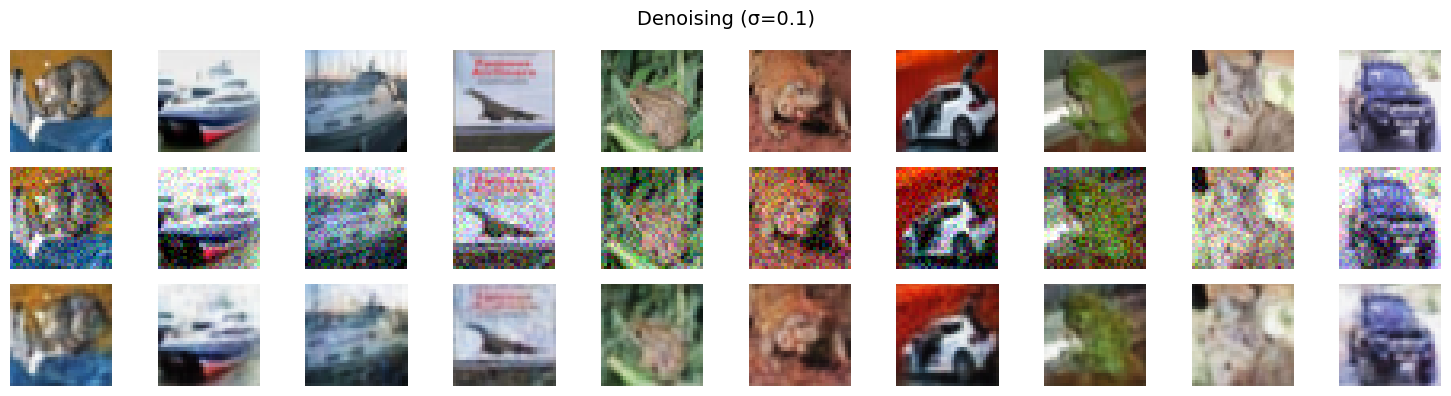

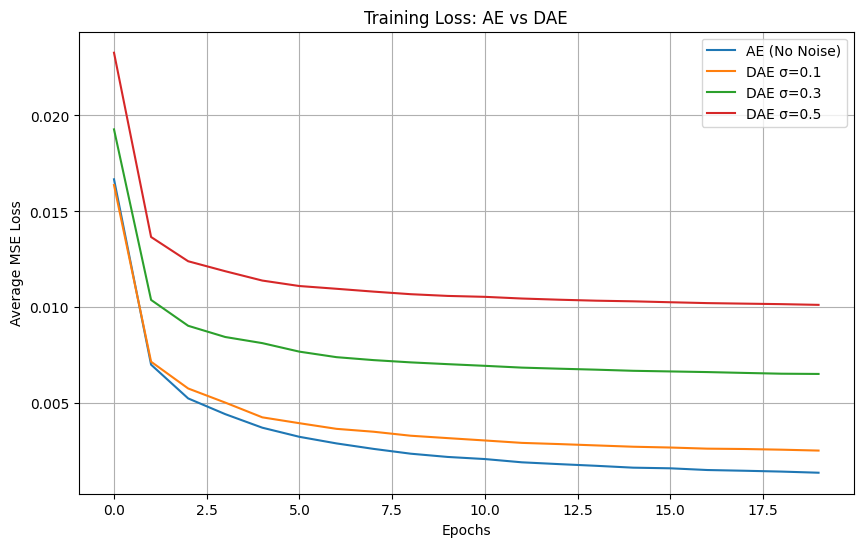

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


AE Feature Accuracy: 0.3242 | Time: 5.82s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


DAE σ=0.1 DAE Feature Accuracy: 0.3096 | Time: 4.99s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


DAE σ=0.3 DAE Feature Accuracy: 0.3164 | Time: 5.82s
DAE σ=0.5 DAE Feature Accuracy: 0.3975 | Time: 5.00s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
if __name__ == "__main__":
    main()

## When to Use AE vs. DAE for feature learning?

- **Autoencoders**:
  - When the input is clean and we are focused on compression or basic unsupervised learning.

- **Denoising Autoencoders**:
  - When data contains noise
  - When we want to learn more generalizable features.
  - For image restoration, denoising, or outlier detection.




